# ⚙️ Initiez-vous au MLOps (partie 1/2)

## 🤖 Modélisation
### 🛠️ Préparez l'environnement de travail
#### 📦 Import des modules python

In [22]:
import os
import shutil
import sys
import time
import warnings
warnings.filterwarnings("ignore")
import pickle

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
os.unsetenv('MLFLOW_TRACKING_URI')
os.unsetenv('MLFLOW_HOME')

import logging
# Réduire le niveau de verbosité de MLflow
logging.getLogger('mlflow').setLevel(logging.ERROR)

import pyarrow
import pandas as pd
import numpy as np

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    make_scorer, 
    fbeta_score,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    ConfusionMatrixDisplay
)

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import shap

# Modules internes
from src.models.seuil import complete_threshold_optimization
from src.visualization.visu import plot_vertical_feature_importance
from src.visualization.visu_text import (print_title,
                                          print_end, 
                                          print_col,
                                          quick_df_info,print_results)
from src.models.modelization import (
    print_report,
    print_cross_validation_scores,
)
from src.utils_mlflow import (
    log_global_params_and_tags,
    create_experiment_with_metadata,
    start_experiment,
    log_global_params_and_tags,
    log_base_metrics,
    log_complete_system_metrics,
    log_feature_importance_with_names,
    log_shap_artifacts
)
# Constantes
from src.constantes import (
    NOTEBOOK_NAME, 
    TRACKING_URI, 
    TAGS_DEFAULT,
    TAGS_BASELINE,
    TAGS_CV, 
    TAGS_TO,
    TAGS_LGBMO ,
    TAGS_FINAL_MODEL,
    EXPERIMENT)

### Préparation du jeu de données

In [23]:
df = pd.read_parquet("../data/processed/survey_lung_cancer_features.parquet", engine='pyarrow')
# Conversion des colonnes booléennes en int pour compatibilité avec certains modèles
bool_cols = df.select_dtypes(include=['bool', 'boolean']).columns
df[bool_cols] = df[bool_cols].astype(int)
# Conversion des colonnes catégorielles en codes numériques
cat_cols = df.select_dtypes(include=['category']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)

quick_df_info(df)


┌-------------------------------* Information *-------------------------------┐
├─------- Shape: (17940, 31) - Colonnes:
├─ID                        int64     
├─GENDER                    int64     
├─AGE                       float64   
├─LUNG_CANCER               int64     
├─SMOKING                   int64     
├─YELLOW_FINGERS            int64     
├─ANXIETY                   int64     
├─PEER_PRESSURE             int64     
├─CHRONIC DISEASE           int64     
├─FATIGUE                   int64     
├─ALLERGY                   int64     
├─WHEEZING                  int64     
├─ALCOHOL CONSUMING         int64     
├─COUGHING                  int64     
├─SHORTNESS OF BREATH       int64     
├─SWALLOWING DIFFICULTY     int64     
├─CHEST PAIN                int64     
├─SMOKING_x_AGE             float64   
├─SMOKING_x_ALCOHOL         int64     
├─RESPIRATORY_SYMPTOMS      int64     
├─TOTAL_SYMPTOMS            int64     
├─BEHAVIORAL_RISK_SCORE     int64     
├─SEVERE_SYMPTOMS   

### ⛓️‍💥 Separation du jeu de données

In [24]:
# ================================
# SÉPARATION TRAIN / VALIDATION / TEST
# ================================

y = df["LUNG_CANCER"]
X = df.drop(columns=["LUNG_CANCER", "ID", "YELLOW_FINGERS", "ANXIETY"])

print_title(f"Données originales: {X.shape[0]} échantillons")
print_col(f"Distribution: Classe 0: {(y == 0).sum()}, Classe 1: {(y == 1).sum()}")
print_col(f"Proportion classe 1: {(y == 1).mean()*100:.1f}%")
print_end()

# Étape 1: Séparer train+val (80%) / test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% pour test
    random_state=42,
    stratify=y,  # Garde la même proportion de classes
)

# Étape 2: Séparer train (60%) / validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 25% de 80% = 20% du total
    random_state=42,
    stratify=y_temp,
)

# ================================
# VÉRIFICATION DES PROPORTIONS
# ================================

total = len(X)
print_title("RÉPARTITION FINALE:")
print_col(f" Train:      {len(X_train)} échantillons ({len(X_train)/total*100:.1f}%)")
print_col(f" Validation: {len(X_val)} échantillons ({len(X_val)/total*100:.1f}%)")
print_col(f" Test:       {len(X_test)} échantillons ({len(X_test)/total*100:.1f}%)")
print_end()

print_title("VÉRIFICATION STRATIFICATION:")
print_col(f" Original    - Classe 1: {(y == 1).mean()*100:.1f}%")
print_col(f" Train       - Classe 1: {(y_train == 1).mean()*100:.1f}%")
print_col(f" Validation  - Classe 1: {(y_val == 1).mean()*100:.1f}%")
print_col(f" Test        - Classe 1: {(y_test == 1).mean()*100:.1f}%")
print_end()

quick_df_info(X_train)


┌------------------* Données originales: 17940 échantillons *------------------┐
├─Distribution: Classe 0: 2319, Classe 1: 15621
├─Proportion classe 1: 87.1%
└------------------------------------------------------------------------------┘

┌---------------------------* RÉPARTITION FINALE: *---------------------------┐
├─ Train:      10764 échantillons (60.0%)
├─ Validation: 3588 échantillons (20.0%)
├─ Test:       3588 échantillons (20.0%)
└------------------------------------------------------------------------------┘

┌-----------------------* VÉRIFICATION STRATIFICATION: *-----------------------┐
├─ Original    - Classe 1: 87.1%
├─ Train       - Classe 1: 87.1%
├─ Validation  - Classe 1: 87.1%
├─ Test        - Classe 1: 87.1%
└------------------------------------------------------------------------------┘

┌-------------------------------* Information *-------------------------------┐
├─------- Shape: (10764, 27) - Colonnes:
├─GENDER                    int64     
├─AGE             


### ➡️ Choix des modèles :
- DummyClassifier
- LogisticRegression
- RandomForestClassifier
- XGBClassifier
- LGBMClassifier


In [25]:
dummy_pipeline = ImbPipeline([ 
    ('oversampling', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('model', DummyClassifier(strategy="constant", constant=1)) 
])
rl_pipeline = ImbPipeline([ 
    ('oversampling', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42)) 
])
rf_pipeline = ImbPipeline([ 
    ('oversampling', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42)) 
])
xgb_pipeline = ImbPipeline([
    ('oversampling', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(random_state=42))
])
lgb_pipeline = ImbPipeline([
    ('oversampling', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(
        random_state=42,
        verbose=-1  # Désactiver les warnings
    ))
])

models_pipelines = {
    "Dummy": dummy_pipeline,
    "Logistic Regression": rl_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline,
    "LightGBM": lgb_pipeline
}


### Initialisation MLflow

In [26]:
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.xgboost.autolog(disable=True)
mlflow.lightgbm.autolog(disable=True)
mlflow.autolog(disable=True) # Désactivation de l'autologging pour éviter les conflits
# ⚠️ IMPORTANT : Activer AVANT start_run()
mlflow.enable_system_metrics_logging()

### 🤖 Baseline

In [27]:
# Définir l'expérience (ou la créer si elle n'existe pas)
model_type="baseline_comparison"
EXPERIMENT_NAME = EXPERIMENT + " - " + model_type
description="Expérience pour comparer les modèles de base sur la détection du cancer du poumon."
 
experiment_id=start_experiment(EXPERIMENT_NAME, description, TAGS_DEFAULT | TAGS_BASELINE)

model_scores = []
for name, pipeline in models_pipelines.items():
    
    with mlflow.start_run(experiment_id=experiment_id, run_name=f"Run {name}") as parent_run:
        log_global_params_and_tags(X_train, X_test, df, TAGS_DEFAULT | TAGS_BASELINE | 
                                   {"model_name": name})
        mlflow.set_tag("mlflow.note.content", f"{name} - {model_type}")
        mlflow.log_param("model_type", model_type)

        print_title(f"Entraînement du modèle: {name}")
        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Afficher le rapport
        accuracy, precision, recall, f1, f2 = print_report(
            y_test, y_pred, target_names=["Non", "Oui"]
        )

        # 1. Log des paramètres spécifiques au modèle (e.g., type de modèle)
        mlflow.log_param("model_name", name)
        
        # 2. Log des métriques (ce sont des nombres)
        log_base_metrics( accuracy, precision, recall, f1, f2)


        # 3. Utilise la saveur MLflow pour scikit-learn (et pour les autres modèles avec pipelines)
        mlflow.sklearn.log_model(
            sk_model=pipeline, 
            artifact_path="model"
        )
    

        model_score = {
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "F2-score": f2,
        }
        model_scores.append(model_score)
        print_end()
# Tableau des performances des modèles
print_results(model_scores)

ℹ️  Expérience existante: Lung Cancer Detection - baseline_comparison
✅ Description ajoutée
✅ 13 tag(s) ajouté(s)

┌----------------------* Entraînement du modèle: Dummy *----------------------┐

┌--------------------------* PERFORMANCE DU MODÈLE *--------------------------┐
├─ Accuracy (Exactitude):       0.871 │ (TP+TN)/(TP+TN+FP+FN)
├─ Precision (Précision):       0.871 │ TP/(TP+FP) | Minimiser les faux positifs. 
├─ Recall (Sensibilité):        1.000 │ TP/(TP+FN) | Minimiser les faux négatif. 
├─ F1-score:                    0.931 │ 2*Precision*Recall/(Precision+Recall)
├─ F2-score:                    0.971 │ 5*Precision*Recall/(4*Precision+Recall) | Privilégie le rappel)
└------------------------------------------------------------------------------┘

┌---------------------------* MATRICE DE CONFUSION *---------------------------┐
├─ RÉALITÉ \ PRÉDICTION
|                      Non         Oui
|          Non           0         464
|          Oui           0        3124
|
├─ Détail

### ❎  Validation croisée

In [28]:
models_pipelines = {
    "Logistic Regression": rl_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline,
    "LightGBM": lgb_pipeline
}
model_scores = []

# Définir l'expérience (ou la créer si elle n'existe pas)
model_type="cross-validation"
EXPERIMENT_NAME = EXPERIMENT + " - " + model_type
description="Expérience de validation croisée pour comparer les modèles sur la détection du cancer du poumon."
 
experiment_id=start_experiment(EXPERIMENT_NAME, description, TAGS_DEFAULT | TAGS_CV)

#  Validation croisée : Xtrain+Xtest, on utilise X_train + X_test
X_cv = pd.concat([X_train, X_test], axis=0)
y_cv = pd.concat([y_train, y_test], axis=0)

for name, pipeline in models_pipelines.items():

    with mlflow.start_run(experiment_id=experiment_id, run_name=f"Run CV {name}") as parent_run:
                
        log_global_params_and_tags(X_train, X_test, df, TAGS_DEFAULT | TAGS_CV | 
                                   {"model_name": name})
        mlflow.set_tag("mlflow.note.content", f"{name} - {model_type}")
        mlflow.log_param("model_type", model_type)


        # Métriques système avant
        print("📊 État système avant entraînement:")
        metrics_before = log_complete_system_metrics()
        for key, value in metrics_before.items():
            if 'percent' in key:
                print(f"   {key}: {value:.1f}%")
            elif 'gb' in key or 'mb' in key:
                print(f"   {key}: {value:.2f}")
    
        mlflow.log_metrics({f"system/{k}_before": v for k, v in metrics_before.items()})
    
        # Entraînement
        print("\n🏋️ Entraînement en cours...")
        start_time = time.time()
        accuracy, precision, recall, f1, f2, stable = (
            print_cross_validation_scores(pipeline, X_cv, y_cv)
        )
        training_time = time.time() - start_time
        # Métriques système après
        print("\n📊 État système après entraînement:")
        metrics_after = log_complete_system_metrics()
        for key, value in metrics_after.items():
            if 'percent' in key:
                print(f"   {key}: {value:.1f}%")
        
        mlflow.log_metrics({f"system/{k}_after": v for k, v in metrics_after.items()})
        
        # Métriques de performance
        mlflow.log_metrics({
            'system/training_time_seconds': training_time,
            'system/training_time_minutes': training_time / 60,
        })


         # 1. Log des paramètres spécifiques au modèle (e.g., type de modèle)
        mlflow.log_param("model_name", name)
        
        # 2. Log des métriques (ce sont des nombres)
        log_base_metrics( accuracy, precision, recall, f1, f2)
        mlflow.log_param("stability", stable)

        mlflow.sklearn.log_model(
            sk_model=pipeline, 
            artifact_path="models"
        )
    
        model_score = {
                    "Model": name,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall,
                    "F1-score": f1,
                    "F2-score": f2,
                    "Stabilité": stable,
                }
        model_scores.append(model_score)
# Tableau des performances des modèles
print_results(model_scores)

ℹ️  Expérience existante: Lung Cancer Detection - cross-validation
✅ Description ajoutée
✅ 13 tag(s) ajouté(s)
📊 État système avant entraînement:
   system_cpu_percent: 10.7%
   system_memory_total_gb: 16.00
   system_memory_available_gb: 3.79
   system_memory_used_percent: 76.3%
   system_disk_used_percent: 4.0%
   system_disk_free_gb: 271.67
   process_memory_rss_mb: 554.80
   process_memory_vms_mb: 426979.19

🏋️ Entraînement en cours...

┌------------------* VALIDATION CROISÉE LogisticRegression *------------------┐
├─ Accuracy: 0.796 (+/- 0.020) [CV: 0.013]
├─ Précision: 0.870 (+/- 0.003) [CV: 0.002]
├─ Rappel:    0.899 (+/- 0.023) [CV: 0.013]
├─ F1-Score:  0.885 (+/- 0.013) [CV: 0.007]
├─ F2-Score:  0.893 (+/- 0.019) [CV: 0.010]
|
├─ Stabilité precision:  0.002 ✅ Stable
├─ Stabilité recall:  0.013 ✅ Stable
├─ Stabilité f1:  0.007 ✅ Stable
├─ Stabilité f2:  0.010 ✅ Stable
└------------------------------------------------------------------------------┘

📊 État système après entraîne

### 📈 Calcul des seuils

ℹ️  Expérience existante: Lung Cancer Detection - threshold_optimization
✅ Description ajoutée
✅ 13 tag(s) ajouté(s)

┌--------* Optimisation du seuil pour le modèle: Logistic Regression *--------┐

┌----------------------* OPTIMISATION F2 VIA COURBE PR: *----------------------┐
├─Seuil optimal: 0.001
├─F2-Score: 0.9712
├─Précision: 0.8707
├─Rappel: 1.0000


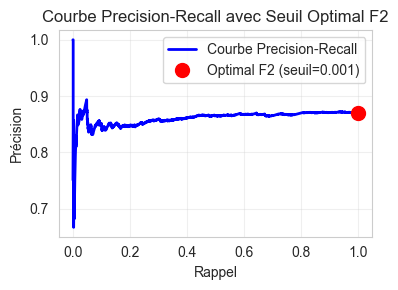

├─✅ Meilleur seuil trouvé via courbe PR: 0.001 (F2: 0.9712)


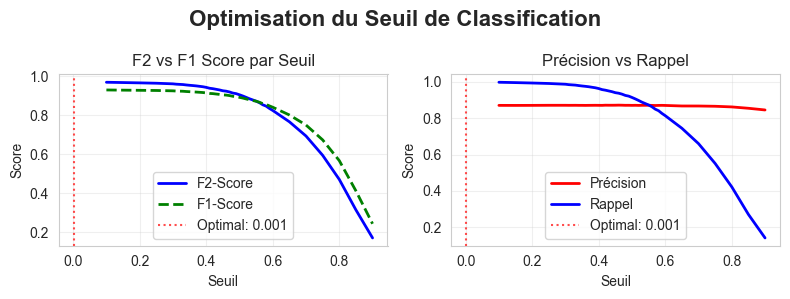

├─ RÉSUMÉ FINAL:
├─ Seuil optimal: 0.001
├─ Amélioration F2: +0.0660
├─ Amélioration F1: +0.0389
├─
├─F2-Score final sur test: 0.9709
└------------------------------------------------------------------------------┘

┌--------------------------* PERFORMANCE DU MODÈLE *--------------------------┐
├─ Accuracy (Exactitude):       0.870 │ (TP+TN)/(TP+TN+FP+FN)
├─ Precision (Précision):       0.871 │ TP/(TP+FP) | Minimiser les faux positifs. 
├─ Recall (Sensibilité):        1.000 │ TP/(TP+FN) | Minimiser les faux négatif. 
├─ F1-score:                    0.931 │ 2*Precision*Recall/(Precision+Recall)
├─ F2-score:                    0.971 │ 5*Precision*Recall/(4*Precision+Recall) | Privilégie le rappel)
└------------------------------------------------------------------------------┘

┌---------------------------* MATRICE DE CONFUSION *---------------------------┐
├─ RÉALITÉ \ PRÉDICTION
|                      Non         Oui
|          Non           0         464
|          Oui           1    

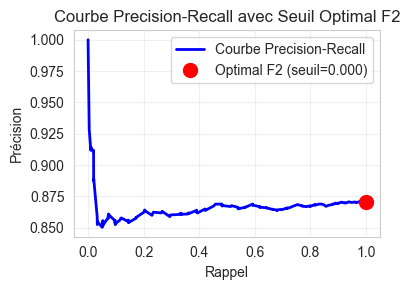

├─✅ Meilleur seuil trouvé via courbe PR: 0.000 (F2: 0.9712)


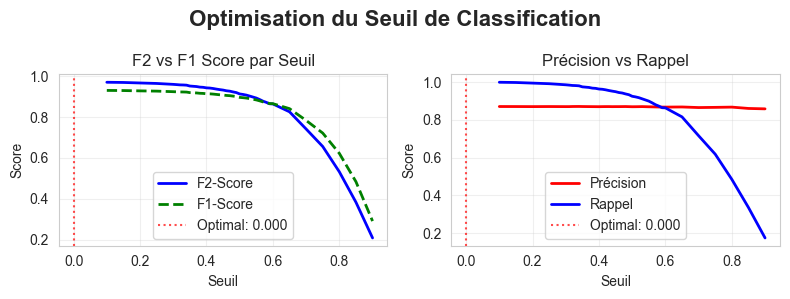

├─ RÉSUMÉ FINAL:
├─ Seuil optimal: 0.000
├─ Amélioration F2: +0.0519
├─ Amélioration F1: +0.0307
├─
├─F2-Score final sur test: 0.9712
└------------------------------------------------------------------------------┘

┌--------------------------* PERFORMANCE DU MODÈLE *--------------------------┐
├─ Accuracy (Exactitude):       0.871 │ (TP+TN)/(TP+TN+FP+FN)
├─ Precision (Précision):       0.871 │ TP/(TP+FP) | Minimiser les faux positifs. 
├─ Recall (Sensibilité):        1.000 │ TP/(TP+FN) | Minimiser les faux négatif. 
├─ F1-score:                    0.931 │ 2*Precision*Recall/(Precision+Recall)
├─ F2-score:                    0.971 │ 5*Precision*Recall/(4*Precision+Recall) | Privilégie le rappel)
└------------------------------------------------------------------------------┘

┌---------------------------* MATRICE DE CONFUSION *---------------------------┐
├─ RÉALITÉ \ PRÉDICTION
|                      Non         Oui
|          Non           0         464
|          Oui           0    

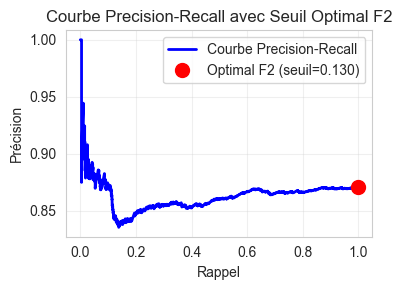

├─✅ Meilleur seuil trouvé via courbe PR: 0.130 (F2: 0.9712)


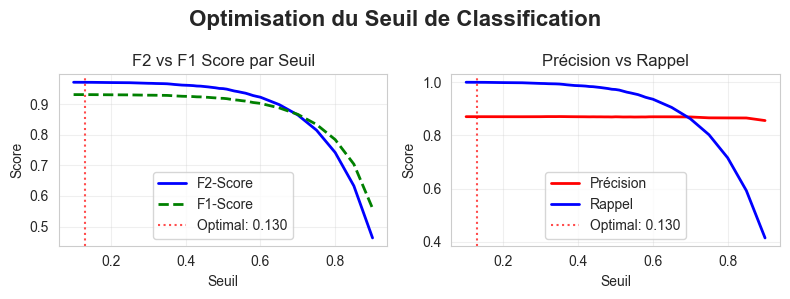

├─ RÉSUMÉ FINAL:
├─ Seuil optimal: 0.130
├─ Amélioration F2: +0.0208
├─ Amélioration F1: +0.0122
├─
├─F2-Score final sur test: 0.9712
└------------------------------------------------------------------------------┘

┌--------------------------* PERFORMANCE DU MODÈLE *--------------------------┐
├─ Accuracy (Exactitude):       0.871 │ (TP+TN)/(TP+TN+FP+FN)
├─ Precision (Précision):       0.871 │ TP/(TP+FP) | Minimiser les faux positifs. 
├─ Recall (Sensibilité):        1.000 │ TP/(TP+FN) | Minimiser les faux négatif. 
├─ F1-score:                    0.931 │ 2*Precision*Recall/(Precision+Recall)
├─ F2-score:                    0.971 │ 5*Precision*Recall/(4*Precision+Recall) | Privilégie le rappel)
└------------------------------------------------------------------------------┘

┌---------------------------* MATRICE DE CONFUSION *---------------------------┐
├─ RÉALITÉ \ PRÉDICTION
|                      Non         Oui
|          Non           0         464
|          Oui           0    

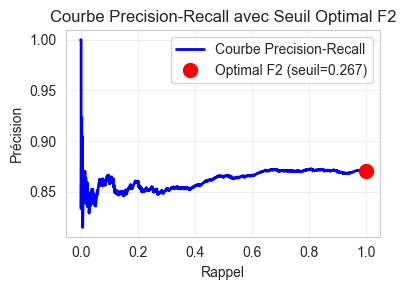

├─✅ Meilleur seuil trouvé via courbe PR: 0.267 (F2: 0.9712)


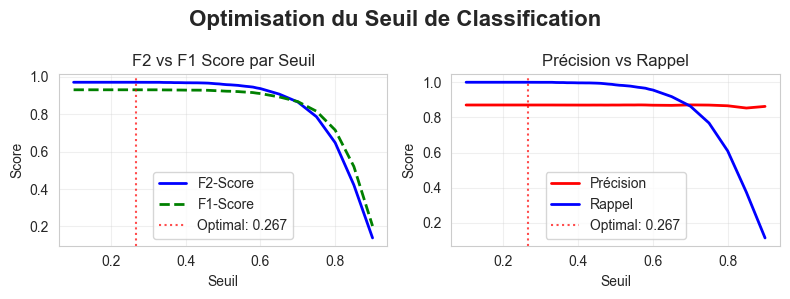

├─ RÉSUMÉ FINAL:
├─ Seuil optimal: 0.267
├─ Amélioration F2: +0.0112
├─ Amélioration F1: +0.0065
├─
├─F2-Score final sur test: 0.9712
└------------------------------------------------------------------------------┘

┌--------------------------* PERFORMANCE DU MODÈLE *--------------------------┐
├─ Accuracy (Exactitude):       0.871 │ (TP+TN)/(TP+TN+FP+FN)
├─ Precision (Précision):       0.871 │ TP/(TP+FP) | Minimiser les faux positifs. 
├─ Recall (Sensibilité):        1.000 │ TP/(TP+FN) | Minimiser les faux négatif. 
├─ F1-score:                    0.931 │ 2*Precision*Recall/(Precision+Recall)
├─ F2-score:                    0.971 │ 5*Precision*Recall/(4*Precision+Recall) | Privilégie le rappel)
└------------------------------------------------------------------------------┘

┌---------------------------* MATRICE DE CONFUSION *---------------------------┐
├─ RÉALITÉ \ PRÉDICTION
|                      Non         Oui
|          Non           1         463
|          Oui           0    

In [29]:
# Modèle sans paramètres optimisés
models_pipelines = {
    "Logistic Regression": rl_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline,
    "LightGBM": lgb_pipeline
}
model_scores = []
# Définir l'expérience (ou la créer si elle n'existe pas)
model_type="threshold_optimization"
EXPERIMENT_NAME = EXPERIMENT + " - " + model_type
description="Optimisation du seuil de décision pour maximiser le F2-score sur la détection du cancer du poumon."
 
experiment_id=start_experiment(EXPERIMENT_NAME, description, TAGS_DEFAULT | TAGS_TO)


for name, pipeline in models_pipelines.items():
    with mlflow.start_run(experiment_id=experiment_id, run_name=f"Run threshold {name}") as parent_run:

        log_global_params_and_tags(X_train, X_test, df, TAGS_DEFAULT | TAGS_TO | 
                                   {"model_name": name})
        mlflow.set_tag("mlflow.note.content", f"{name} - {model_type}")
        mlflow.log_param("model_type", model_type)

         # 1. Entraîner le modèle sur train

        print_title(f"Optimisation du seuil pour le modèle: {name}")
        # Entraînement
        model = pipeline.fit(X_train, y_train)

        # 2. Optimiser le seuil sur validation
        optimal_threshold, eval_results = complete_threshold_optimization(model, X_val, y_val)

        # 3. Évaluation finale sur test avec seuil optimal
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

        final_f2 = fbeta_score(y_test, y_test_pred, beta=2)
        print_col("")
        print_col(f"F2-Score final sur test: {final_f2:.4f}")
        print_end()

        accuracy, precision, recall, f1, f2 = print_report(
            y_test, y_test_pred, target_names=["Non", "Oui"]
        )
        model_score = {
                "Model": name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1,
                "F2-score": f2,
                "Optimal Threshold": optimal_threshold,
            }
        log_base_metrics( accuracy, precision, recall, f1, f2)
        mlflow.log_metric("Optimal Threshold", optimal_threshold)
        mlflow.sklearn.log_model(
            sk_model=pipeline, 
            artifact_path="models"
        )
        model_scores.append(model_score)
        print_end()
# Tableau des performances des modèles
print_results(model_scores)

### 🧮 Hyperparameter LightGBM

In [10]:
# Fermer tous les runs actifs s'il y en a
while mlflow.active_run():
    mlflow.end_run()

print("✅ Tous les runs actifs ont été fermés")

# Pipeline

pipeline = ImbPipeline([
    ('oversampling', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        objective='multiclass',
        num_class=3,
        verbose=-1
    ))
])


# Grille
param_grid = {
    'classifier__num_leaves': [15, 31, 63],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, -1]
}

# === SCORING AVEC F2 ===
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
    'f2': f2_scorer
}

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=scoring,
    refit='f2',  # Optimiser sur F2 (crucial pour détection médicale)
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

# Définir l'expérience (ou la créer si elle n'existe pas)
model_type="LGBM_optimization"
EXPERIMENT_NAME = EXPERIMENT + " - " + model_type
description="Optimisation du modèle LGBM."
 
experiment_id=start_experiment(EXPERIMENT_NAME, description, TAGS_DEFAULT | TAGS_LGBMO)

    
print("🔍 GridSearch optimisé pour F2 score...")

# Entraîner
grid_search.fit(X_train, y_train)

with mlflow.start_run(experiment_id=experiment_id, run_name=f"LGBM-optimization") as parent_run:
    # === LOGGER LES MEILLEURS RÉSULTATS ===
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("optimized_on", "f2_score")

    # Logger les meilleurs scores CV pour chaque métrique
    print(f"\n📊 Best CV Scores:")
    for metric in scoring.keys():
        best_score = grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_]
        mlflow.log_metric(f"best_cv_{metric}", best_score)
        print(f"   {metric}: {best_score:.4f}")

    # === ÉVALUATION TEST ===
    y_pred = grid_search.predict(X_test)

    test_metrics = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred, average='weighted'),
        'test_recall': recall_score(y_test, y_pred, average='weighted'),
        'test_f1': f1_score(y_test, y_pred, average='weighted'),
        'test_f2': fbeta_score(y_test, y_pred, beta=2, average='weighted')
    }

    mlflow.log_metrics(test_metrics)

    print(f"\n📈 Test Metrics:")
    for metric, value in test_metrics.items():
        print(f"   {metric}: {value:.4f}")

    # === LOGGER LE MODÈLE ===
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")

    # === LOGGER LES CONFIGURATIONS (NESTED RUNS) ===
    cv_results = grid_search.cv_results_

    print(f"\n📝 Logging {len(cv_results['params'])} configurations...")

    for i in range(len(cv_results['params'])):
        
        with mlflow.start_run(run_name=f"config_{i}", nested=True):
            
            # Paramètres
            params = cv_results['params'][i]
            mlflow.log_params(params)
            
            # Métriques pour toutes les métriques de scoring
            for metric in scoring.keys():
                mlflow.log_metrics({
                    f'mean_test_{metric}': cv_results[f'mean_test_{metric}'][i],
                    f'std_test_{metric}': cv_results[f'std_test_{metric}'][i],
                    f'mean_train_{metric}': cv_results[f'mean_train_{metric}'][i]
                })
            
            # Rank
            mlflow.log_metric("rank_test_f2", cv_results['rank_test_f2'][i])
            
            # Tags
            mlflow.set_tag("is_best", i == grid_search.best_index_)
            mlflow.set_tag("config_id", i)

    # === TAGS ET DESCRIPTION ===
    mlflow.set_tags({
        'model_type': 'LightGBM',
        'search_method': 'GridSearchCV',
        'optimization_metric': 'F2',
        'dataset': 'lung_cancer'
    })


    results=f"""
        # GridSearch Results - Optimized for F2 Score
        
        ## Why F2?
        F2 score gives **2x more weight to recall** than precision.
        This is crucial for medical detection where **missing a positive case (false negative) is much worse than a false positive**.
        
        ## Best Parameters
    ```
        {grid_search.best_params_}
    ```
        
        ## Best CV Scores
        - Accuracy: {cv_results['mean_test_accuracy'][grid_search.best_index_]:.4f}
        - Precision: {cv_results['mean_test_precision'][grid_search.best_index_]:.4f}
        - Recall: {cv_results['mean_test_recall'][grid_search.best_index_]:.4f}
        - F1: {cv_results['mean_test_f1'][grid_search.best_index_]:.4f}
        - **F2: {cv_results['mean_test_f2'][grid_search.best_index_]:.4f}**
        
        ## Test Performance
        - Accuracy: {test_metrics['test_accuracy']:.4f}
        - Precision: {test_metrics['test_precision']:.4f}
        - Recall: {test_metrics['test_recall']:.4f}
        - F1: {test_metrics['test_f1']:.4f}
        - **F2: {test_metrics['test_f2']:.4f}**
        """

    mlflow.set_tag(
        "mlflow.note.content", results
    )


    print_title("RÉSULTATS FINAUX DU GRIDSEARCH")
    print(results)
    print_end()

    print(f"\n✅ GridSearch complet avec F2!")


✅ Tous les runs actifs ont été fermés
ℹ️  Expérience existante: Lung Cancer Detection - LGBM_optimization
✅ Description ajoutée
✅ 13 tag(s) ajouté(s)
🔍 GridSearch optimisé pour F2 score...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

📊 Best CV Scores:
   accuracy: 0.8686
   precision: 0.7858
   recall: 0.8686
   f1: 0.8110
   f2: 0.8445

📈 Test Metrics:
   test_accuracy: 0.8676
   test_precision: 0.7679
   test_recall: 0.8676
   test_f1: 0.8095
   test_f2: 0.8433

📝 Logging 81 configurations...
🏃 View run config_0 at: http://127.0.0.1:5010/#/experiments/10/runs/70185e19b54541fc8410bda662847fba
🧪 View experiment at: http://127.0.0.1:5010/#/experiments/10
🏃 View run config_1 at: http://127.0.0.1:5010/#/experiments/10/runs/6d1deca4c6db4c4cb275dd76877116f8
🧪 View experiment at: http://127.0.0.1:5010/#/experiments/10
🏃 View run config_2 at: http://127.0.0.1:5010/#/experiments/10/runs/6af9828db1654b83ac59381826728ee0
🧪 View experiment at: http://127.0.0.1:5010/#/experiments

### Modèle Finale

✅ Tous les runs actifs ont été fermés
ℹ️  Expérience existante: Lung Cancer Detection - LGBM_Final_model
✅ Description ajoutée
✅ 13 tag(s) ajouté(s)
🔍 Entraînement du modèle final avec les meilleurs paramètres...

┌--------------------------* PERFORMANCE DU MODÈLE *--------------------------┐
├─ Accuracy (Exactitude):       0.866 │ (TP+TN)/(TP+TN+FP+FN)
├─ Precision (Précision):       0.871 │ TP/(TP+FP) | Minimiser les faux positifs. 
├─ Recall (Sensibilité):        0.994 │ TP/(TP+FN) | Minimiser les faux négatif. 
├─ F1-score:                    0.928 │ 2*Precision*Recall/(Precision+Recall)
├─ F2-score:                    0.967 │ 5*Precision*Recall/(4*Precision+Recall) | Privilégie le rappel)
└------------------------------------------------------------------------------┘

┌---------------------------* MATRICE DE CONFUSION *---------------------------┐
├─ RÉALITÉ \ PRÉDICTION
|                      Non         Oui
|          Non           2         462
|          Oui          18      

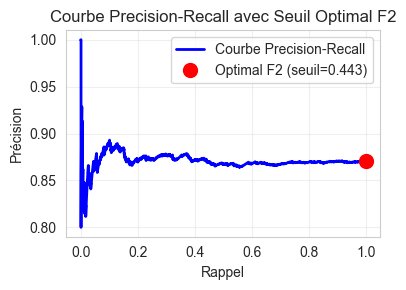

├─✅ Meilleur seuil trouvé via courbe PR: 0.443 (F2: 0.9712)


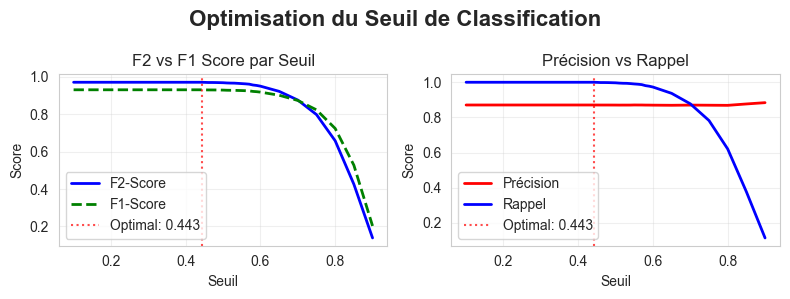

├─ RÉSUMÉ FINAL:
├─ Seuil optimal: 0.443
├─ Amélioration F2: +0.0025
├─ Amélioration F1: +0.0016
├─
├─F2-Score final sur test: 0.9695
└------------------------------------------------------------------------------┘

┌--------------------------* PERFORMANCE DU MODÈLE *--------------------------┐
├─ Accuracy (Exactitude):       0.869 │ (TP+TN)/(TP+TN+FP+FN)
├─ Precision (Précision):       0.871 │ TP/(TP+FP) | Minimiser les faux positifs. 
├─ Recall (Sensibilité):        0.998 │ TP/(TP+FN) | Minimiser les faux négatif. 
├─ F1-score:                    0.930 │ 2*Precision*Recall/(Precision+Recall)
├─ F2-score:                    0.969 │ 5*Precision*Recall/(4*Precision+Recall) | Privilégie le rappel)
└------------------------------------------------------------------------------┘

┌---------------------------* MATRICE DE CONFUSION *---------------------------┐
├─ RÉALITÉ \ PRÉDICTION
|                      Non         Oui
|          Non           1         463
|          Oui           7    

Registered model 'LungCancer_LightGBM_Final' already exists. Creating a new version of this model...
Created version '40' of model 'LungCancer_LightGBM_Final'.


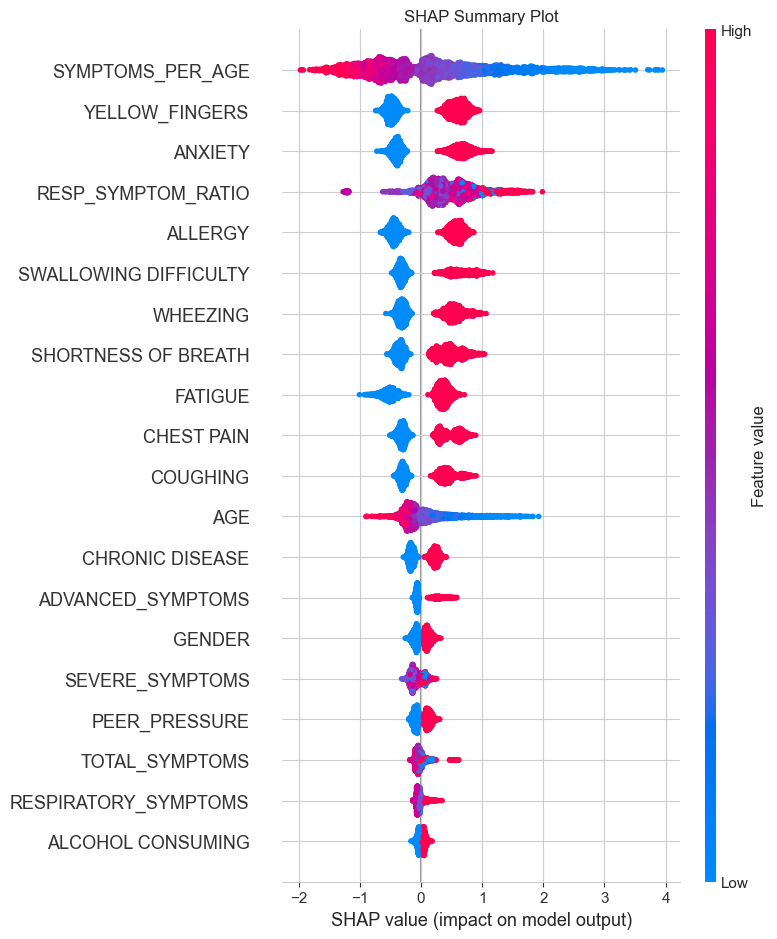

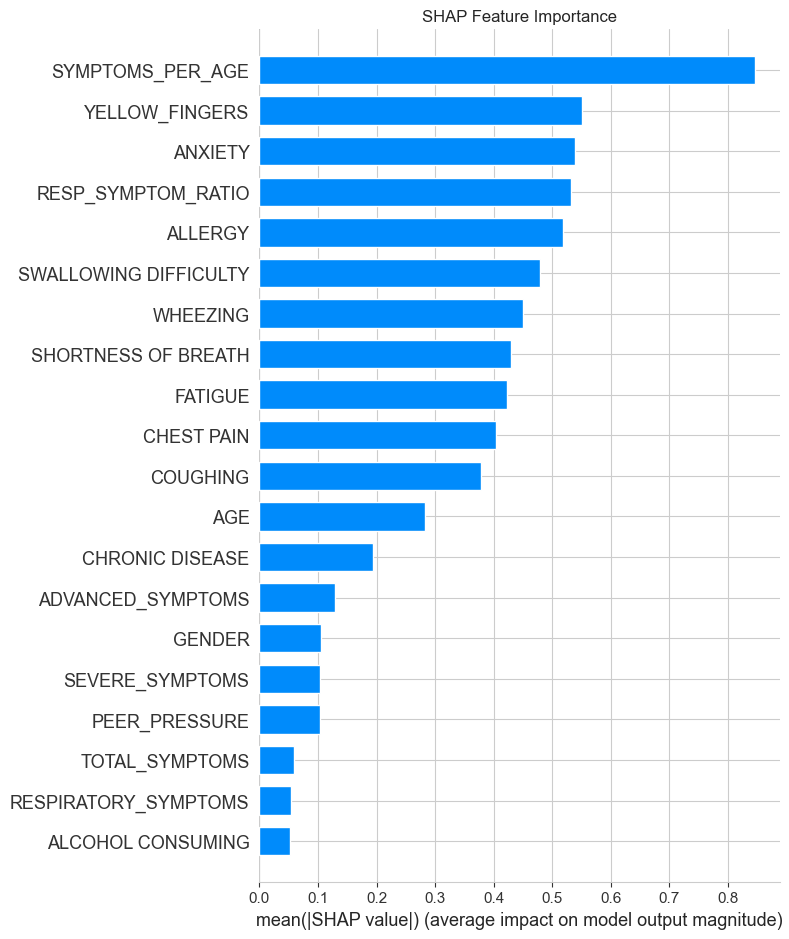

✅ Tous les artifacts SHAP sauvegardés dans MLflow!
🏃 View run bright-ape-898 at: http://127.0.0.1:5010/#/experiments/11/runs/c1301969f0194be7aa3b9452ea5d66d2
🧪 View experiment at: http://127.0.0.1:5010/#/experiments/11


In [11]:
# Fermer tous les runs actifs s'il y en a
while mlflow.active_run():
    mlflow.end_run()
print("✅ Tous les runs actifs ont été fermés")

# Créer un ColumnTransformer qui préserve les noms
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X_train.columns.tolist())
    ],
    remainder='passthrough'
)

# Pipeline avec noms préservés
pipeline_with_names = ImbPipeline([
    ('oversampling', SMOTE(random_state=42)),
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        objective='multiclass',
        num_class=3,
        verbose=-1,
        **grid_search.best_params_
    ))
])

pipeline_final = ImbPipeline([
    ('oversampling', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        verbose=-1,
        **grid_search.best_params_
    ))
])

# Définir l'expérience (ou la créer si elle n'existe pas)
model_type="LGBM_Final_model"
EXPERIMENT_NAME = EXPERIMENT + " - " + model_type
description="Modèle final optimisé LGBM avec les meilleurs paramètres."
 
experiment_id=start_experiment(EXPERIMENT_NAME, description, TAGS_DEFAULT | TAGS_FINAL_MODEL)

model_scores = []
log_global_params_and_tags(X_train, X_test, df, TAGS_DEFAULT | TAGS_FINAL_MODEL | 
                                   {"model_name": name})
mlflow.set_tag("mlflow.note.content", f"{name} - {model_type}")
mlflow.log_param("model_type", model_type)
             
# Logger les meilleurs hyperparamètres du GridSearch
mlflow.log_params(grid_search.best_params_)
mlflow.log_param("source", "gridsearch_optimization")

print("🔍 Entraînement du modèle final avec les meilleurs paramètres...")
start_time = time.time()
model_final = pipeline_final.fit(X_train, y_train)
training_time = time.time() - start_time

mlflow.log_metric("system/training_time_seconds", training_time)
y_pred = model_final.predict(X_test)
# Afficher le rapport
accuracy, precision, recall, f1, f2 = print_report(
    y_test, y_pred, target_names=["Non", "Oui"]
)

mlflow.log_metrics({
        'initial_accuracy': accuracy,
        'initial_precision': precision,
        'initial_recall': recall,
        'initial_f1': f1,
        'initial_f2': f2
    })

 # === CROSS-VALIDATION ===

cv_accuracy, cv_precision, cv_recall, cv_f1, cv_f2, stable = (
        print_cross_validation_scores(pipeline_final, X_train, y_train)
    )
mlflow.log_metrics({
        'cv_accuracy': cv_accuracy,
        'cv_precision': cv_precision,
        'cv_recall': cv_recall,
        'cv_f1': cv_f1,
        'cv_f2': cv_f2,
    })
mlflow.log_param("stability", stable)

# === OPTIMISATION DU THRESHOLD ===

optimal_threshold, eval_results = complete_threshold_optimization(model_final, X_val, y_val)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)
mlflow.log_param("optimal_threshold", optimal_threshold)
# Logger les résultats de l'optimisation du threshold si disponibles
if eval_results:
    for key, value in eval_results.items():
        if isinstance(value, (int, float)):
            mlflow.log_metric(f"threshold_opt_{key}", value)


final_f2 = fbeta_score(y_test, y_test_pred, beta=2)
print_col("")
print_col(f"F2-Score final sur test: {final_f2:.4f}")
print_end()

# Rapport final
final_accuracy, final_precision, final_recall, final_f1, final_f2 = print_report(
    y_test, y_test_pred, target_names=["Non", "Oui"]
)

mlflow.log_metrics({
    'final_accuracy': final_accuracy,
    'final_precision': final_precision,
    'final_recall': final_recall,
    'final_f1': final_f1,
    'final_f2': final_f2
})


cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non", "Oui"])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Final Model')
plt.tight_layout()
plt.savefig('confusion_matrix_final.png', dpi=100, bbox_inches='tight')
mlflow.log_artifact('confusion_matrix_final.png')
plt.close()
os.remove('confusion_matrix_final.png')


print("\n🎯 Feature Importance...")
    
fi_df = log_feature_importance_with_names(
        pipeline=pipeline_final,
        X_train=X_train,
        mlflow_enabled=True
    )


# === TAGS ===
tags = {
    'model_type': 'LightGBM',
    'pipeline': 'SMOTE + StandardScaler + LightGBM',
    'optimization': 'GridSearch + Threshold',
    'status': 'production_ready',
    'threshold_optimized': 'yes'}


model_metadata = {
    "description": "Modèle final optimisé pour la détection de cancer",
    "author": "François Hellebuyck",
    **tags
}

signature = infer_signature(X_train, y_test_pred_proba)

mlflow.sklearn.log_model(
    sk_model=model_final,
    artifact_path="final_model",
    signature=signature,
    input_example=X_train[:5],
    registered_model_name="LungCancer_LightGBM_Final",
    metadata=model_metadata
)

mlflow.set_tags(tags)

log_shap_artifacts(model_final, X_test, classifier_name="classifier", 
                   scaler_name="scaler", prefix="final_model_shap")

# === DESCRIPTION DÉTAILLÉE ===
description_text = f"""
# Modèle Final de Détection de Cancer du Poumon

## Pipeline
1. **SMOTE** - Gestion du déséquilibre des classes
2. **StandardScaler** - Normalisation des features
3. **LightGBM** - Classificateur optimisé

## Hyperparamètres (issus de GridSearch)
```python
{grid_search.best_params_}
```

## Optimisation du Threshold
- **Threshold optimal**: {optimal_threshold:.4f}
- Optimisé sur le set de validation pour maximiser le F2-score

## Performance Cross-Validation (5-fold)
- Accuracy: {cv_accuracy:.4f}
- Precision: {cv_precision:.4f}
- Recall: {cv_recall:.4f}
- F1: {cv_f1:.4f}
- **F2**: {cv_f2:.4f}
- Stabilité: {stable}

## Performance Test Set (avec threshold par défaut 0.5)
- Accuracy: {accuracy:.4f}
- Precision: {precision:.4f}
- Recall: {recall:.4f}
- F1: {f1:.4f}
- F2: {f2:.4f}

## Performance Test Set (avec threshold optimisé {optimal_threshold:.4f})
- Accuracy: {final_accuracy:.4f}
- Precision: {final_precision:.4f}
- Recall: {final_recall:.4f}
- F1: {final_f1:.4f}
- **F2**: {final_f2:.4f}

## Amélioration grâce au threshold
- Δ F2: {final_f2 - f2:+.4f}
- Δ Recall: {final_recall - recall:+.4f}
- Δ Precision: {final_precision - precision:+.4f}

## Temps d'entraînement
- {training_time:.2f} secondes

## Top 5 Features
{fi_df.head(5)[['feature', 'importance']].to_string(index=False)}

---
**Modèle prêt pour la production** 🚀
"""
    
mlflow.set_tag("mlflow.note.content", description_text)


# Fermer tous les runs actifs s'il y en a
while mlflow.active_run():
    mlflow.end_run()
